In [1]:
import numpy as np
import pylab as plt
import pickle as pkl
from scipy.optimize import minimize

In [2]:
# Dear all: Get this pickle file from the discord server!
with open("data.pkl", "rb") as handle:
    data = pkl.load(handle).T # check out that pesky little `.T`
#print(data.shape)

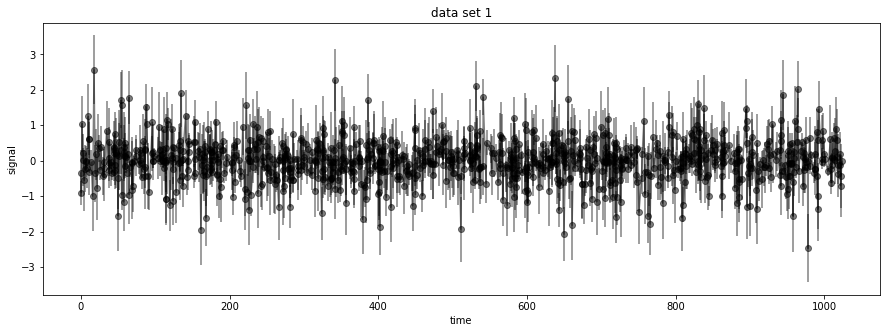

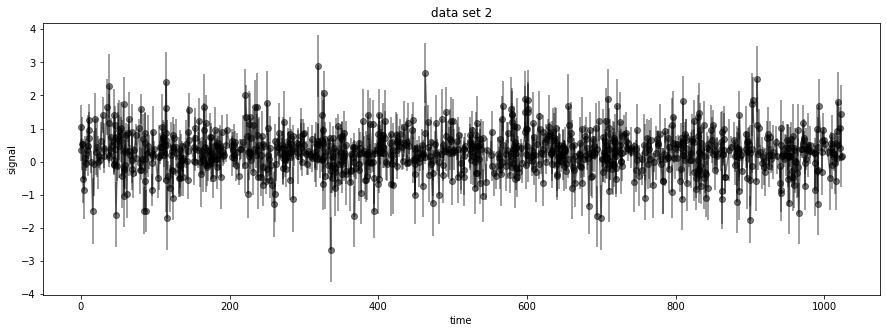

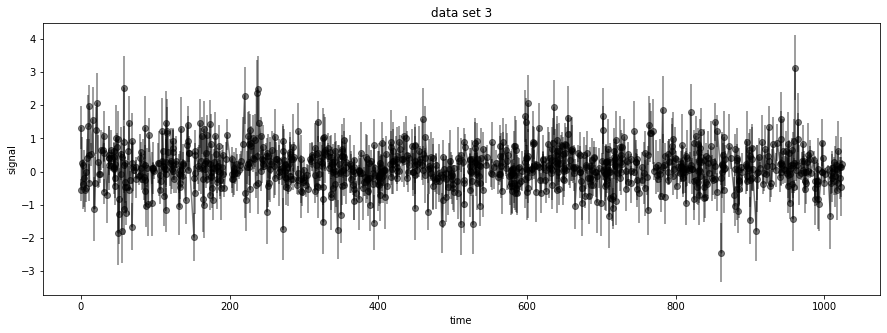

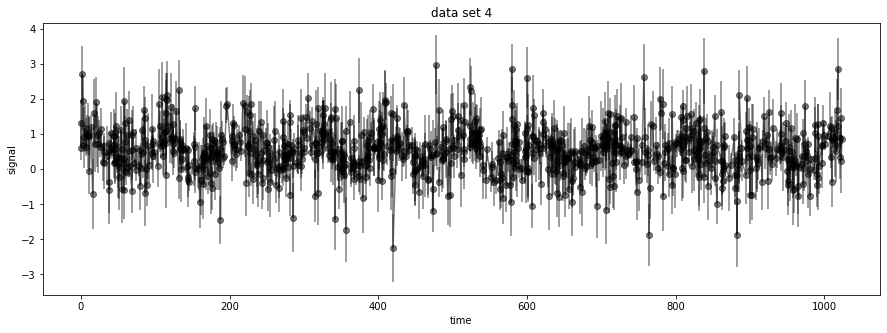

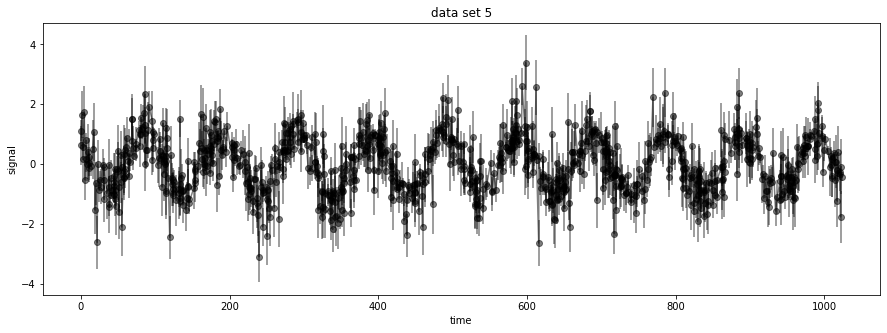

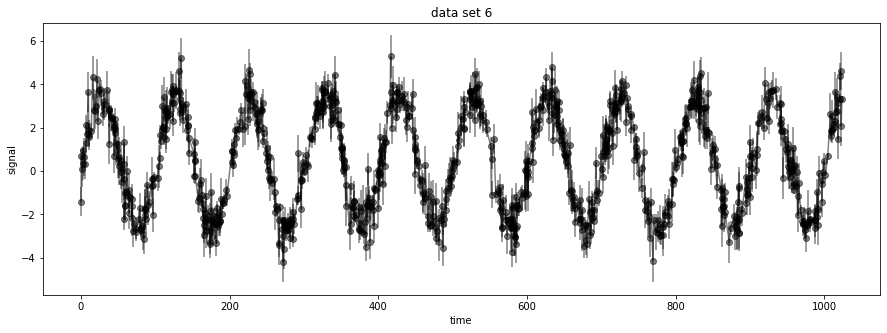

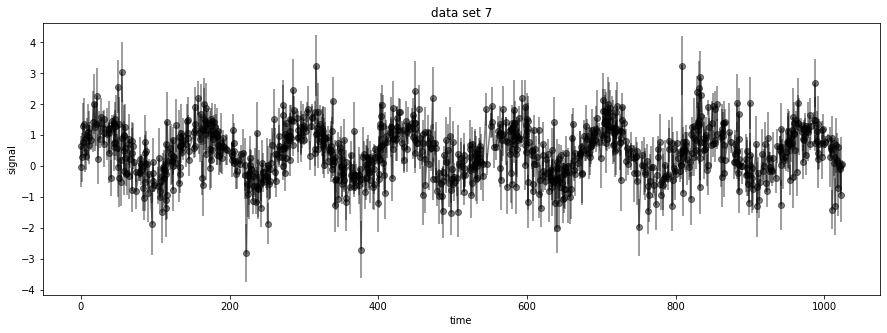

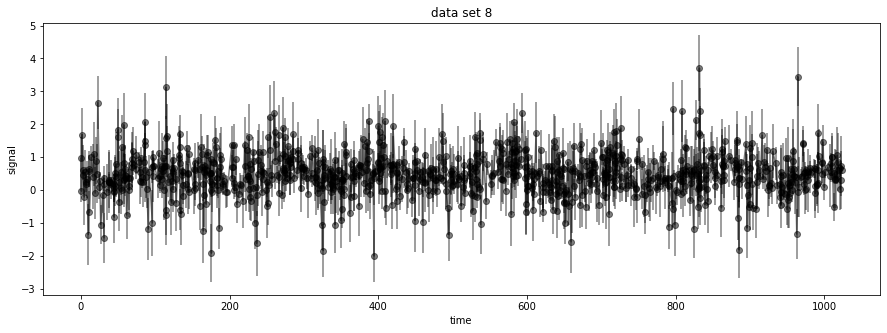

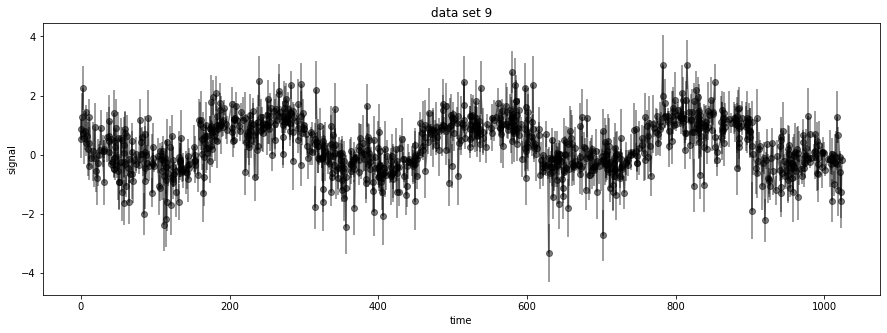

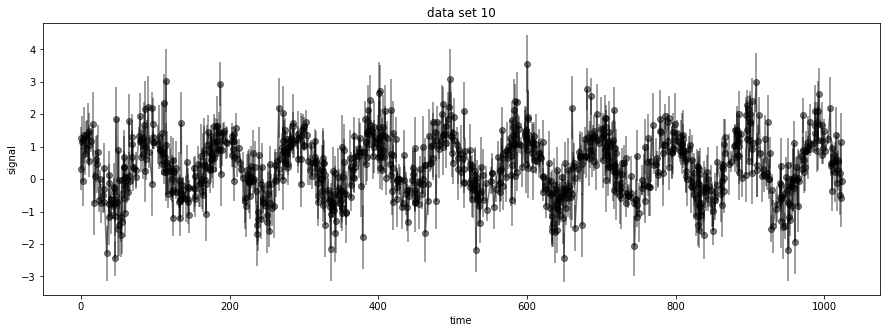

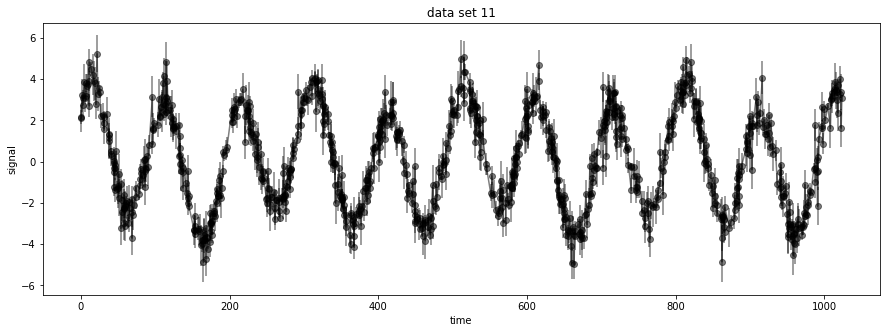

In [3]:
# Dear all:
# - data[0] is the array of times (day units, say?)
# - data[1] is the array of uncertainties (m/s units, say?)
# - data[2:13] are data sets (m/s units, say?).
# There are 11 data sets in all; they are illustrated in this code block.
for i in range(2, 13):
    plt.figure(figsize=(15, 5))
    plt.errorbar(data[0], data[i], yerr=data[1],
                 color="k", marker="o", alpha=0.5)
    plt.xlabel("time")
    plt.ylabel("signal")
    plt.title("data set {}".format(i-1))

In [4]:
#initialize some variables
x = data[0]
y = data[2]
sig = data[1]

In [5]:
def fit(xvals,A,B,C,D):
    return A*np.sin((2*np.pi/B)*(xvals+C))+D    

In [6]:
def fit1(xvals,A,B,C,D,a,b,c,):
    return A*np.sin((2*np.pi/B)*(xvals+C))+D + a*np.sin((2*np.pi/b)*(xvals+c))

In [7]:
#negative log liklihood
def loglike(params):
    
    global sig, x, y
    fit_func = fit(x,params[0],params[1],params[2],params[3])
    chi = 0
    for i in range(len(fit_func)):
        chi+= (((fit_func[i]-y[i])**2)/(sig[i]**2))
    return 0.5*chi

In [8]:
#negative log liklihood for two signals
def loglike1(params):
    
    global sig, x, y
    fit_func = fit1(x,params[0],params[1],params[2],params[3],params[4],params[5],params[6])
    chi = 0
    for i in range(len(fit_func)):
        chi+= (((fit_func[i]-y[i])**2)/(sig[i]**2))
    return 0.5*chi

In [9]:
def SNR(signal,noise):
    ps = 0
    pn = 0
    for i in range(len(signal)):
        ps+=signal[i]**2
        pn+=(noise[i]-signal[i])**2  
        #you can dispense with dividing each by the number of elements N because they have the same N
    return ps/pn

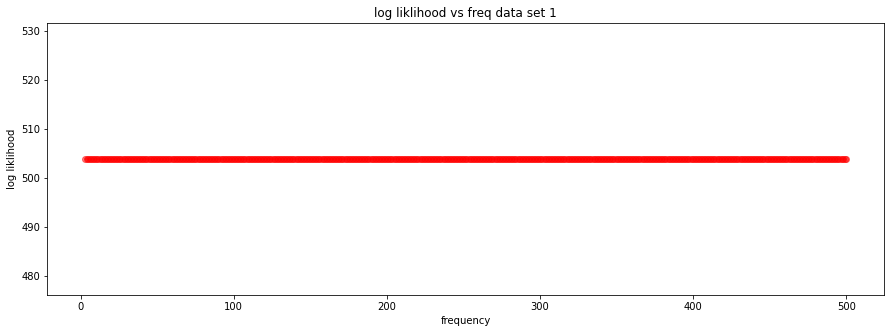

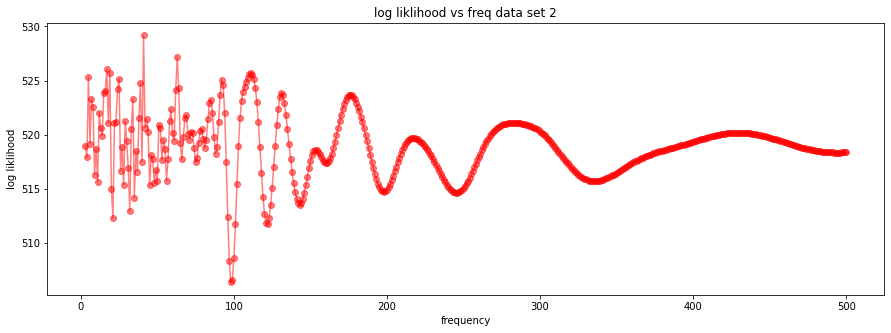

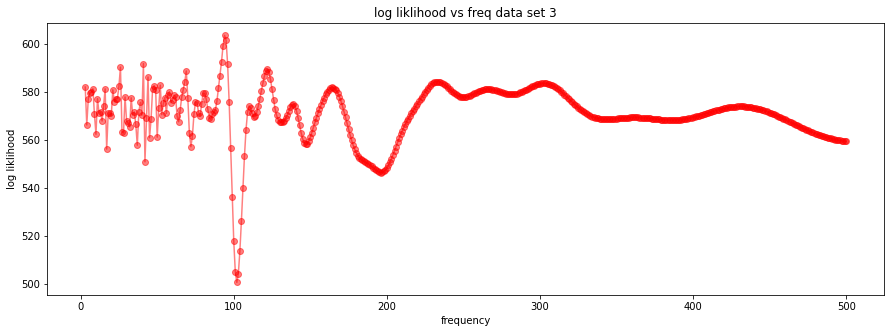

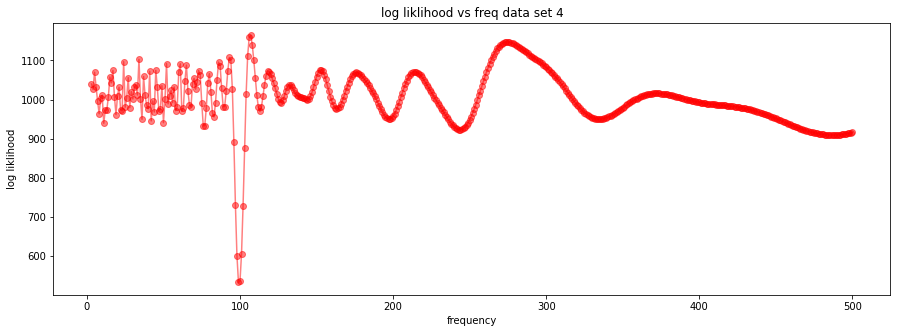

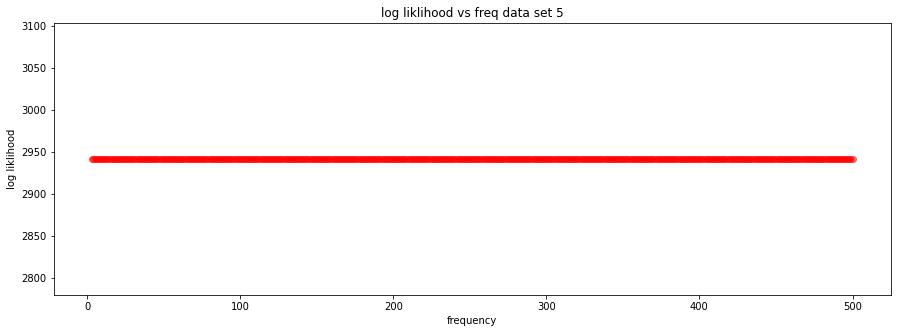

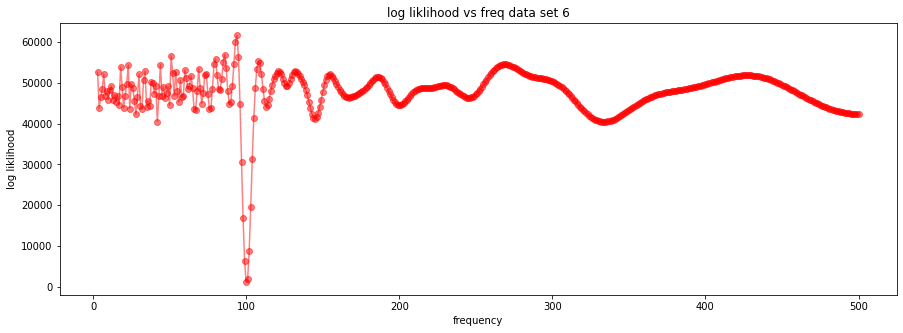

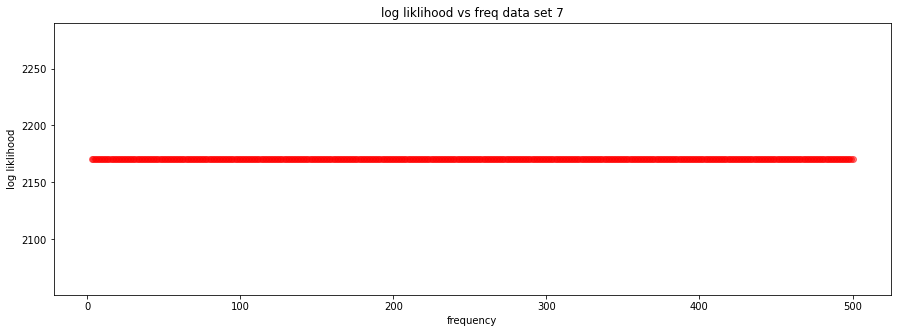

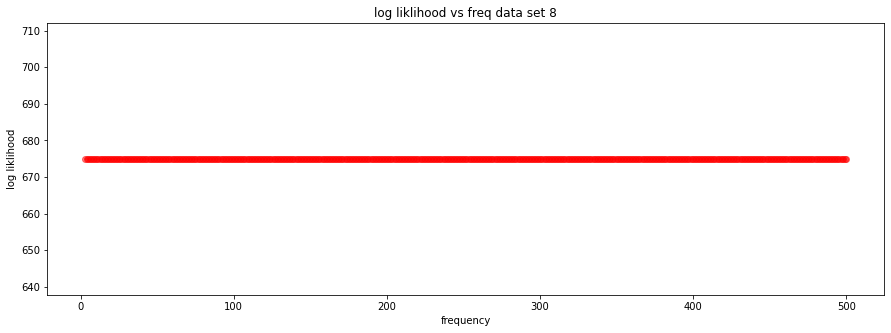

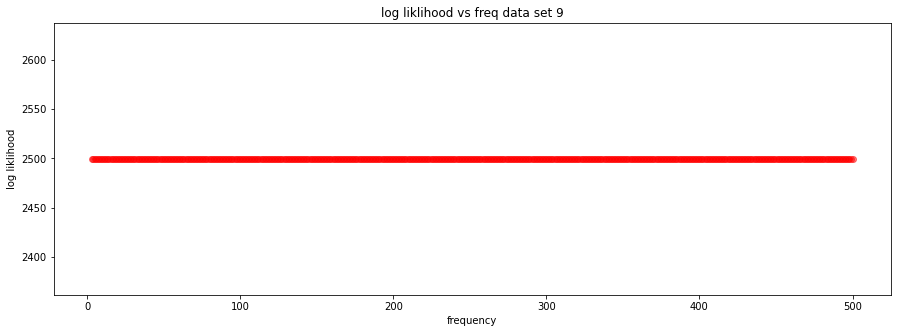

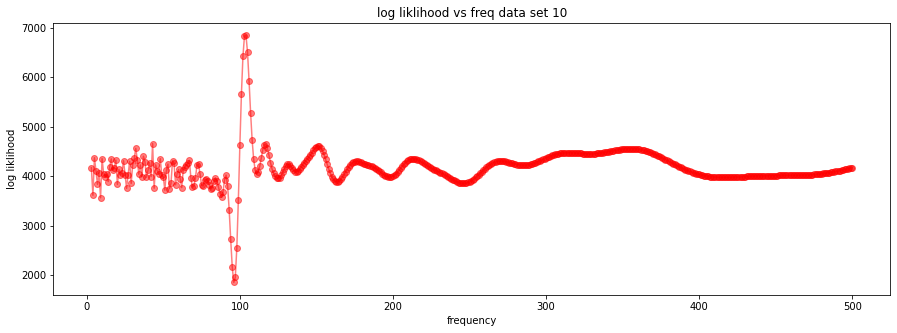

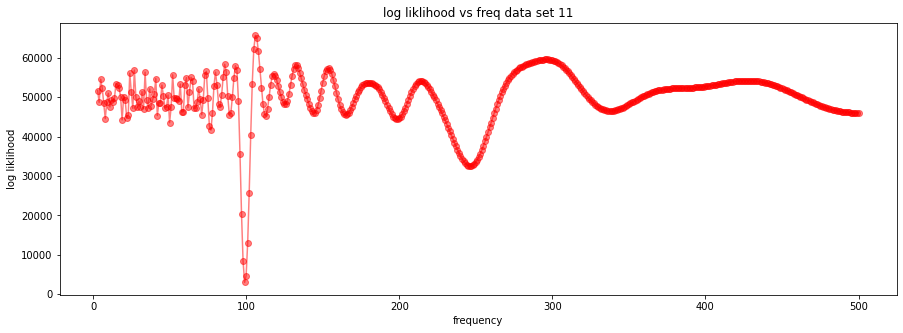

In [10]:
#plot the logliklihood for each possible frequency
for i in range(2, 13):
    y=data[i]
    res = minimize(loglike,[0.5,100,np.pi/2,0.1],bounds = [(0,10),(90.0,102),(0,2*np.pi),(-5,5)])
    A,B,C,D = res.x[0],res.x[1], res.x[2] ,res.x[3]
    sweep = np.linspace(3,500,498)
    logs = []
    for j in sweep:
        logs.append(loglike([A,j,C,D]))
    plt.figure(figsize=(15, 5))
    plt.plot(sweep,logs,color="r", marker="o", alpha=0.5)
    plt.xlabel("frequency")
    plt.ylabel("log liklihood")
    plt.title("log liklihood vs freq data set {}".format(i-1))

We can see that only following data sets have a signal at 100 days, that minimizes the negative log liklihood.
Data sets: 2,3,4,6,11.

We will now find the amplitude of the 100 day signals by minimizing the fit function. Then we will set up the general uncertainty matrix. [A.T*C^-1*A]^-1. Where C is the diagonal matrix whose elements are given by the squares of the uncertainty from the second data set in the file. A will be the a 2 x N matrix where N is the dimension of the x data. The first column of A will be all ones for the DC offset. The second column will be sin[(2*pi/100)(x-phi)] where phi is the phase shift, which we will get from the minimization, for finding the amplitude, Amp. Then the general uncertainty matrix will give us uncertainty in D and Amp. 

In [11]:
for i in range(2, 13):
    if (i-1) in [2,3,4,6,11]:
        y=data[i]
        res = minimize(loglike,[0.5,100,np.pi/4,0.1],bounds = [(0,10),(99.99,100.01),(0,2*np.pi),(-5,5)])
        Amp,B,C,D = res.x[0],res.x[1], res.x[2] ,res.x[3]
        A =  np.array([np.ones(len(x)),np.sin(2*np.pi/100*(x-C))]) #this is really A transpose because of the way numpy works
        C_in = np.diagflat(1/(sig)**2)
        var_Amp = np.sqrt(np.linalg.inv((A@C_in)@A.T)[1][1])
        print('The amplitude for the 100 day signal in data set', i-1, 'is', Amp ,'with uncertainty',var_Amp,'.')

The amplitude for the 100 day signal in data set 2 is 0.049235108408064936 with uncertainty 0.013696501692913038 .
The amplitude for the 100 day signal in data set 3 is 0.08948594339519099 with uncertainty 0.013653846831696664 .
The amplitude for the 100 day signal in data set 4 is 0.29975034708471454 with uncertainty 0.013696501692913038 .
The amplitude for the 100 day signal in data set 6 is 2.97896607144802 with uncertainty 0.013653846831696664 .
The amplitude for the 100 day signal in data set 11 is 2.8849548897646025 with uncertainty 0.013696501692913038 .


I was ititally queezy that all the signals should have the same uncertainty. But thats because they all have the same uncertainty! Also the relative size of the uncertainty is different for each signal. So the really small amplitude signals have uncertainty on the order of the amplitude which sits right with me.

Now, I'm going to subtract the signal we got in this first part and see if there are any other signals. I'm going to do this in a dumb way. First I'm going to optimize the logliklihood function for the first signal and then assume there is another signal, and optimize for two signals assuming that one is very close to the 100 day signal I found.

In [12]:
#consider the same procedure but assume there are two signals
seconds = []
for i in range(2, 13):
    if (i-1) in [2,3,4,6,11]:
        y=data[i]
        res = minimize(loglike,[0.5,100,np.pi/2,0.1],bounds = [(0,10),(99,101),(0,2*np.pi),(-5,5)])
        Amp,B,C,D = res.x[0],res.x[1], res.x[2] ,res.x[3]
#         res1 = minimize(loglike1,[Amp,B,C,D,0.2,50,np.pi],bounds = [(.999*Amp,1.001*Amp),(.999*B,1.001*B),(.999*C,2*np.pi),(.999*D,1.001*D),
#                                                                     (0,1),(2,500.0),(0,2*np.pi)])
        y = data[i]-fit(x,Amp,B,C,D)
        res1 = minimize(loglike,[Amp/5,200,np.pi/2,0.1],bounds = [(0,Amp),(2,500),(0,2*np.pi),(D-0.01,D+0.01)])
        a,b,c = res1.x[0],res1.x[1], res1.x[2]
        A =  np.array([np.ones(len(x)),np.sin(2*np.pi/b*(x-c))]) #this is really A transpose because of the way numpy works
        C_in = np.diagflat(1/(sig)**2)
        var_Amp = np.sqrt(np.linalg.inv((A@C_in)@A.T)[1][1])
        seconds.append((b,a))
        if a > 0:
            print('The period for the second signal in data set', i-1, 'is', b ,
                  'with amplitude',a,
              'and amplitude uncertainty',var_Amp,'.')
        
        

The period for the second signal in data set 2 is 206.29864055423548 with amplitude 0.03240395020812595 and amplitude uncertainty 0.01386561689937305 .
The period for the second signal in data set 3 is 199.2345775064167 with amplitude 0.042095829172719805 and amplitude uncertainty 0.014447999447857462 .
The period for the second signal in data set 4 is 207.78577489996366 with amplitude 0.03214493164268268 and amplitude uncertainty 0.013626496548540614 .


We will do a bootstrap uncertainty for the second period.

In [13]:
'find the meaningful other signals with a signal to noise ratio of at least some amount'
secsig = []
for i in range(2, 13):
    y=data[i]
    res = minimize(loglike,[0.5,100,np.pi/2,0.1],bounds = [(0,10),(99.0,100),(0,2*np.pi),(-5,5)])
    A,B,C,D = res.x[0],res.x[1], res.x[2] ,res.x[3]
    y = data[i]-fit(x,A,B,C,D)
    res1 = minimize(loglike,[A/2,200,np.pi,0],bounds = [(0,A),(2,500),(0,2*np.pi),(D-0.01,D+0.01)])
    a,b,c = res1.x[0],res1.x[1], res1.x[2]
    if SNR(fit(x,a,b,c,0),y) > 0.001:
        sweep = np.linspace(20,500,498)
        phase = np.linspace(0,2*np.pi,20)
        logs = [loglike([a,b,c,0])]
        pers = [(b,c)]
        for j in sweep:
            for k in phase:
                lik  = loglike([a,j,k,0])
                if lik < logs[-1]:
                    logs.append(lik)
                    pers.append((j,k))
        per = pers[-1]
        secsig.append((i,a,per[0],per[1]))
        print('The second siganl for data set',i-1,'has period',per[0])
#     plt.figure(figsize=(15, 5))
#     plt.plot(sweep,logs,color="r", marker="o", alpha=0.5)
#     plt.xlabel("frequency")
#     plt.ylabel("log liklihood")
#     plt.title("log liklihood vs freq data set {}".format(i-1))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


The second siganl for data set 2 has period 121.40845070422534
The second siganl for data set 3 has period 104.02414486921529
The second siganl for data set 4 has period 454.60764587525154
The second siganl for data set 6 has period 104.02414486921529
The second siganl for data set 11 has period 248.89336016096578


In [15]:
for m in range(2,13):
    if (m-1) in [2,3,4,6,11]:
        for i in secsig:
            if i[0] == m:
                a,b,c = i[1],i[2],i[3]
        y=data[m] - fit(x,a,b,c,0)
        x = data[0]
        M = 100
        var = np.linspace(0,0,M)
        N = len(x)
        for k in range(M):
            xdata = np.linspace(0,0,N)
            ydata = np.linspace(0,0,N)
            sigma_y = np.linspace(0,0,N)
            for i in range(N):
                j = np.random.randint(0,N)
                xdata[i] = x[j]
                ydata[i] = y[j]
                sigma_y[i] = sig[j]
            y = ydata
            x = xdata
            sig = sigma_y
            res = minimize(loglike,[0.5,100,np.pi/2,0.1],bounds = [(0,10),(99.0,100),(0,2*np.pi),(-5,5)])
            A,B,C,D = res.x[0],res.x[1], res.x[2] ,res.x[3]
            res1 = minimize(loglike1,[Amp,B,C,D,a,b,c],bounds = [(.999*Amp,1.001*Amp),(.999*B,1.001*B),(.9*C,2*np.pi),(D-0.1,0.1+D),
                                                                         (0,a),(.1*b,2*b),(0,2*np.pi)])
            a,b_period,c = res1.x[4],res1.x[5], res1.x[6]
            var[k]=b_period
        var_b = np.sqrt(np.mean(var**2)-np.mean(var)**2)
        print('The bootstrap method for calculating sigma_b on data set ',m-1,'gives',var_b ,'for period',b)

The bootstrap method for calculating sigma_b on data set  2 gives 10.942013424024774 for period 121.40845070422534
The bootstrap method for calculating sigma_b on data set  3 gives 50.57882920724178 for period 104.02414486921529
The bootstrap method for calculating sigma_b on data set  4 gives 1.1453606065764599 for period 454.60764587525154
The bootstrap method for calculating sigma_b on data set  6 gives 3.201981776139456 for period 104.02414486921529
The bootstrap method for calculating sigma_b on data set  11 gives 4.326314118695549 for period 248.89336016096578


Now we subtract this other signal from the original signal to re-estimate the amplitude of the 100 day signal.

In [14]:
for i in range(2, 13):
    if (i-1) in [2,3,4,6,11]:
        for j in secsig:
            if j[0] == i:
                a1,b1,c1 = j[1],j[2],j[3]
        y=data[i]-fit(x,a1,b1,c1,0)
        res = minimize(loglike,[0.05,100,np.pi/2,0.1],bounds = [(0,10),(90.99,110.01),(0,2*np.pi),(-5,5)])
        Amp,B,C,D = res.x[0],res.x[1], res.x[2] ,res.x[3]
        A =  np.array([np.ones(len(x)),np.sin(2*np.pi/100*(x-C))]) #this is really A transpose because of the way numpy works
        C_in = np.diagflat(1/(sig)**2)
        var_Amp = np.sqrt(np.linalg.inv((A@C_in)@A.T)[1][1])
        print('The amplitude for the 100 day signal in data set', i-1, 'is', Amp ,'with uncertainty',var_Amp,'.')

The amplitude for the 100 day signal in data set 2 is 0.052744151044395955 with uncertainty 0.01364346140696785 .
The amplitude for the 100 day signal in data set 3 is 0.09007270682754571 with uncertainty 0.013653846831696664 .
The amplitude for the 100 day signal in data set 4 is 0.3069626897197295 with uncertainty 0.013696501692913038 .
The amplitude for the 100 day signal in data set 6 is 2.9800551472307806 with uncertainty 0.013653846831696664 .
The amplitude for the 100 day signal in data set 11 is 3.028058444871038 with uncertainty 0.013696501692913038 .
